In [1]:
# !pip install requests
# !python -m pip install -U matplotlib

In [2]:
import json
import requests
import pandas as pd
# import matplotlib #as mpl
# import matplotlib.pyplot #as plt

# Data Preparation

## download data from FRED API

###  get_data function: 

#### input: 
- var_list: list of variable codes
- start_date(optional): start date of data(string, YYYY-MM-DD)
- end_date(optional): end date of data(string, YYYY-MM-DD)
- filter_cols(optional): assign if drop==True. the part of var_list to consider when filtering 
- drop: if True, filter the data by min, max date where given variable is available(not NaN)
- freq: assign together with agg variable, aggregate the data to higher frequency
- agg: assign together with freq variable, aggregateion method

#### output:
- data: row=date, columns=variable code, 
- info: the information table to look up the information about the variable
- filter_data: the filtered data with full observations

In [3]:
def use_requests(api_url):
    response = requests.get(api_url)
    json_response = json.loads(response.text)
    return json_response

def get_var_obs(var_list, start_date='1776-07-04', end_date='9999-12-31', freq=None, agg=None):
    
    for i, id_ in enumerate(var_list):
        if (freq!=None)&(agg!=None):
            url='https://api.stlouisfed.org/fred/series/observations?\
            series_id={}&\
            api_key={}&file_type=json&\
            observation_start={}&\
            observation_end={}&\
            frequency={}&\
            aggregation_methoe={}'.format(id_, api_key, start_date, end_date, freq, agg)
            data=use_requests(url)
        else:
            url='https://api.stlouisfed.org/fred/series/observations?\
            series_id={}&\
            api_key={}&file_type=json&\
            observation_start={}&\
            observation_end={}'.format(id_, api_key, start_date, end_date)
            data=use_requests(url)
        
#        print(data)
        df = pd.json_normalize(data['observations'])
        df.drop(columns=['realtime_start','realtime_end'], inplace=True)
        df.rename(columns={'value':'{}'.format(id_)}, inplace=True)
        if i==0:
            final_df=df
        else:
            final_df=final_df.merge(df, how='left',left_on='date',right_on='date')
        
    return final_df
    
    
def get_var_info(var_list):
    
    var_dict=[]

    for i, id_ in enumerate(var_list):
#        print(id_)
        url='https://api.stlouisfed.org/fred/series?\
            series_id={}&\
            api_key={}&file_type=json'.format(id_, api_key)
        try:
            info=use_requests(url)['seriess'][0]    
            var_dict.append(info)
        except KeyError:
            pass
    
    df = pd.json_normalize(var_dict)
    df=df.drop(columns=['realtime_start', 'realtime_end','frequency','units',
                        'seasonal_adjustment','popularity'])
    return df

def get_date_range(df, cols=None, drop=False):
    """return a tuple of the earliest and latest valid data for all columns in the list"""
    if cols==None:
        cols=list(df.columns)
    
    min_date,max_date = df[cols].apply(pd.Series.first_valid_index).max(), df[cols].apply(pd.Series.last_valid_index).min()
    return df.loc[min_date, 'date'], df.loc[max_date, 'date']


def get_data(var_list, start_date='1776-07-04', end_date='9999-12-31', filter_cols=None, drop=False,
            freq=None, agg=None):

    data=get_var_obs(var_list, start_date, end_date, freq=freq, agg=agg)
    info=get_var_info(var_list)
    
    if drop==True:
        if filter_cols==None:
            cols=list(data.columns)
    
    a,b=get_date_range(data, cols=cols, drop=drop)
    
    if drop==True:
        filter_data=data.loc[(data.date >= a) & (data.date <= b)]
        return data, info, filter_data
    else:
        return data, info

###  download the data and metadata using get_data function

#### explanation
- info_allvar: the list of all candidate variables which is composed of 4 sub-components of FRED-MD, var_stock, var_other, and the others
 - 1) FRED-MD: data/DATA.csv file 
 - 2)  var_stock: additional stock market relevant features sourced from FRED (**daily** data and aggregated to **monthly average** data)
 - 3) var_other: additional price, banking relevant features sourced from FRED (**monthly** data)
 - 4) the others: data sourced from OECD, EPU, and NBER and the data are manually downloaded and copied/pasted in data/DATA.csv file(=FRED-MD data csv file)


- info: the metadtata of all candidate variables downloaded using FRED API

** we need to additionally download var_stock and var_other from FRED and merge tham to DATA.csv file

In [4]:
api_key='1bcb66688766335e858be86bd8e202ba'
info_allvar=pd.read_excel('data/FRED-MD_updated_appendix.xlsx')
info_allvar=info_allvar[['tcode','fred','description','group','source']]
info_allvar=info_allvar.rename(columns={'fred':'id'})

## caveat: the most longest series should be the first component of each list
var_stock=list(info_allvar.loc[info_allvar.description.isin(['stock market, daily'])]['id'])
var_other=list(info_allvar.loc[info_allvar.description.isin(['banking','CPI','PCE','PPI','housing'])]['id'])
var_all=list(info_allvar.id)
len(var_other), len(var_stock), len(var_all)

(57, 17, 223)

In [5]:
#api_key='1bcb66688766335e858be86bd8e202ba'
#var_stock=['NASDAQCOM','WILL5000IND','WILL5000INDFC','WILL5000PR','WILL5000PRFC','WILLLRGCAP','WILLLRGCAPGR','WILLLRGCAPVAL','WILLMICROCAP','WILLMIDCAP','WILLMIDCAPGR','WILLMIDCAPVAL','WILLREITIND','WILLRESIND','WILLSMLCAP','WILLSMLCAPGR','WILLSMLCAPVAL']
start_date='1950-01-01'
freq='m'
agg='avg'
drop=True

stock_df, stock_info, filter_stock_df = get_data(var_stock, start_date=start_date, drop=drop, freq=freq, agg=agg)

In [6]:
#api_key='1bcb66688766335e858be86bd8e202ba'
#var_others=['CPIAPPNS','CPIAUCNS','CPIEDUNS','CPIFABNS','CPIHOSNS','CPIMEDNS','CPIOGSNS','CPIRECNS','CPITRNNS','DFXARG3M086SBEA','DGDSRG3M086SBEA','DNRGRG3M086SBEA','DPCMRG3M086SBEA','DPCXRG3M086SBEA','PCEPILFE','WPU03T15M05','WPU057','WPU061','WPU071','WPU081','WPU101','WPU102','WPU114','WPU117','WPU1178','WPU142','ALLACBM027NBOG','AOLACBM027NBOG','BUSLOANSNSA','CASACBM027NBOG','CONSUMERNSA','CREACBM027NBOG','H8B3053NCBDM','H8B3092NCBDM','H8B3094NCBDM','H8B3095NCBDM','INVESTNSA','LCBACBM027NBOG','LOANINVNSA','LOANSNSA','NDFACBM027NBOG','RALACBM027NBOG','REALLNNSA','RREACBM027NBOG','TLAACBM027NBOG','TLBACBM027NBOG']
# start_date='1950-01-01'
# freq='m'
# agg='avg'
# drop=True

other_df, other_info, filter_other_df = get_data(var_other, start_date=start_date, drop=drop)

In [7]:
#var_all=['RPI','W875RX1','DPCERA3M086SBEA','CMRMTSPLx','RETAILx','INDPRO','IPFPNSS','IPFINAL','IPCONGD','IPDCONGD','IPNCONGD','IPBUSEQ','IPMAT','IPDMAT','IPNMAT','IPMANSICS','IPB51222S','IPFUELS','CUMFNS','HWI','HWIURATIO','CLF16OV','CE16OV','UNRATE','UEMPMEAN','UEMPLT5','UEMP5TO14','UEMP15OV','UEMP15T26','UEMP27OV','CLAIMSx','PAYEMS','USGOOD','CES1021000001','USCONS','MANEMP','DMANEMP','NDMANEMP','SRVPRD','USTPU','USWTRADE','USTRADE','USFIRE','USGOVT','CES0600000007','AWOTMAN','AWHMAN','HOUST','HOUSTNE','HOUSTMW','HOUSTS','HOUSTW','PERMIT','PERMITNE','PERMITMW','PERMITS','PERMITW','ACOGNO','AMDMNOx','ANDENOx','AMDMUOx','BUSINVx','ISRATIOx','M1SL','M2SL','M2REAL','BOGMBASE','TOTRESNS','NONBORRES','BUSLOANS','REALLN','NONREVSL','CONSPI','S&P 500','S&P: indust','S&P div yield','S&P PE ratio','FEDFUNDS','CP3Mx','TB3MS','TB6MS','GS1','GS5','GS10','AAA','BAA','COMPAPFFx','TB3SMFFM','TB6SMFFM','T1YFFM','T5YFFM','T10YFFM','AAAFFM','BAAFFM','TWEXAFEGSMTHx','EXSZUSx','EXJPUSx','EXUSUKx','EXCAUSx','WPSFD49207','WPSFD49502','WPSID61','WPSID62','OILPRICEx','PPICMM','CPIAUCSL','CPIAPPSL','CPITRNSL','CPIMEDSL','CUSR0000SAC','CUSR0000SAD','CUSR0000SAS','CPIULFSL','CUSR0000SA0L2','CUSR0000SA0L5','PCEPI','DDURRG3M086SBEA','DNDGRG3M086SBEA','DSERRG3M086SBEA','CES0600000008','CES2000000008','CES3000000008','UMCSENTx','DTCOLNVHFNM','DTCTHFNM','INVEST','VIXCLSx','EPU','CLI_MA','CLI_N','CLI_T','CLI_AC','BCI','CCI','GDP_RTT','GDP_N','GDP_T','BS_PRO','BS_OB','BS_OI','BS_EX','BS_EM','BS_CU','BSI','CS_ECON','CSI','CS_INF','RECESSION','ALLACBM027NBOG','AOLACBM027NBOG','BUSLOANSNSA','CASACBM027NBOG','CONSUMERNSA','CREACBM027NBOG','H8B3053NCBDM','H8B3092NCBDM','H8B3094NCBDM','H8B3095NCBDM','INVESTNSA','LCBACBM027NBOG','LOANINVNSA','LOANSNSA','NDFACBM027NBOG','RALACBM027NBOG','REALLNNSA','RREACBM027NBOG','TLAACBM027NBOG','TLBACBM027NBOG','CPIAPPNS','CPIAUCNS','CPIEDUNS','CPIFABNS','CPIHOSNS','CPIMEDNS','CPIOGSNS','CPIRECNS','CPITRNNS','DFXARG3M086SBEA','DGDSRG3M086SBEA','DNRGRG3M086SBEA','DPCMRG3M086SBEA','DPCXRG3M086SBEA','PCEPILFE','WPU03T15M05','WPU057','WPU061','WPU071','WPU081','WPU101','WPU102','WPU114','WPU117','WPU1178','WPU142','NASDAQCOM','WILL5000IND','WILL5000INDFC','WILL5000PR','WILL5000PRFC','WILLLRGCAP','WILLLRGCAPGR','WILLLRGCAPVAL','WILLMICROCAP','WILLMIDCAP','WILLMIDCAPGR','WILLMIDCAPVAL','WILLREITIND','WILLRESIND','WILLSMLCAP','WILLSMLCAPGR','WILLSMLCAPVAL']
info=get_var_info(var_all)

## strangely, id=IPB51222S fail to get information in the first trial, so do again to catch it
out_var=[x for x in var_all if x not in list(info.id)]
info_out=get_var_info(out_var)

info=pd.concat([info, info_out], ignore_index=True, sort=False) #, ignore_index=True, sort=False

In [8]:
print(len(list(stock_df.columns)[1:])==len(var_stock))
print(len(list(other_df.columns)[1:])==len(var_other))

True
True


In [9]:
## save the information and data downloaded from FRED
info.to_csv (r'data/info.csv', index = False, header=True)
stock_df.to_csv (r'data/stock_df.csv', index = False, header=True)
other_df.to_csv (r'data/other_df.csv', index = False, header=True)

##  Generating full data and full metadata file

##### explanation

- metadata(=full_info): merge metadata of FRED-MD and one from FRED API into one dataframe and calculating the missing values of start, end date of each feature. 
 - we will use this metadata to filter the series with small observations
 
 
- data(=full_data): merge all candidate variables into one data file by expanding the fred-md data(+OECE, NBER, EPU) with newly downloaded additional features such as ones about banking, cpi, ppi, pce, and stock market.

In [10]:
info_from_fred=pd.read_csv('data/info.csv')

In [11]:
len(info_from_fred), len(var_all)
# info_from_fred.columns
# info_allvar.head()
# info_from_fred.head()

(160, 223)

In [12]:
info_all=info_allvar.merge(info_from_fred, how='left', left_on='id', right_on='id')

## tcode, group, source for all variable & 
## title>description
info_all.title=info_all.title.fillna(info_all.description)
info_all=info_all.drop(columns=['description'])

## number of missing information for variables
len(info_all.loc[info_all.observation_start.isna()])
#info_all.loc[info_all.observation_start.isna()]

63

In [13]:
data=pd.read_csv('data/DATA.csv', header=0, skiprows=[1])
stock_data=pd.read_csv('data/stock_df.csv')
other_data=pd.read_csv('data/other_df.csv') ## 수정 필요 가장 긴 시리즈를 왼쪽에 둬야 함.

In [14]:
data2=data.merge(other_data, 
                 how='left', left_on='sasdate', right_on='date')

full_data=data2.merge(stock_data, 
                 how='left', left_on='sasdate', right_on='date'
                     ).drop(columns=['date_x','date_y'])

full_data=full_data.rename(columns={'sasdate':'date'})
full_data=full_data.set_index('date')
full_data.index=pd.to_datetime(full_data.index)   ## revised!

len(data.columns), len(stock_data.columns), len(other_data.columns)

(151, 18, 58)

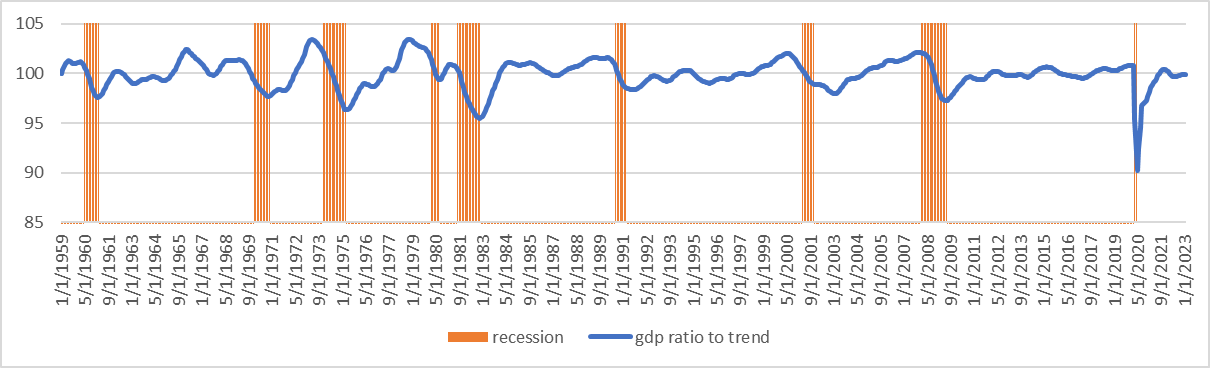
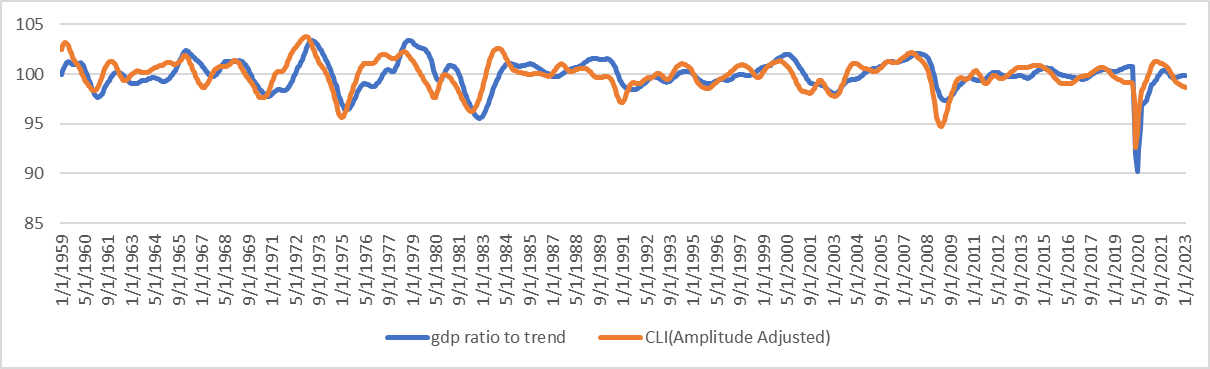

In [15]:
var=[]
start=[]
end=[]

for col in full_data.columns:
    var.append(col)
    min_date = full_data[[col]].apply(pd.Series.first_valid_index).max()
    max_date = full_data[[col]].apply(pd.Series.last_valid_index).min()
    start.append(min_date)
    end.append(max_date)
    
date_range=pd.DataFrame({'id':var, 'start':start, 'end':end})

full_info=info_all.merge(date_range, how='left', on='id'
                       ).drop(columns=['observation_start','observation_end'])

print(len(list(full_info.id))==len(list(full_data.columns)))
#full_data.columns

full_info[['start','end']]=full_info[['start','end']].apply(pd.to_datetime)

False


In [16]:
tb_list=['TB3SMFFM','TB6SMFFM','T1YFFM','T5YFFM','T10YFFM']
tb_name=['3M','6M','1Y','5Y','10Y']
info_var=list(full_info.columns)

for idx, (id1, name1) in enumerate(zip(tb_list[:4], tb_name[:4])):
    for id2, name2 in zip(tb_list[idx+1:],tb_name[idx+1:]):
        info_dict=pd.Series({'tcode':2, 'id':'{}{}'.format(name2,name1), 
                             'group':6, 'source':'FRED',
                             'title':'{} minus {}'.format(name2, name1),
                             'frequency_short':'M',
                             'units_short':'%p',
                             'seasonal_adjustment_short':'NSA',
                             'start':pd.Timestamp(1959,1,1),
                             'end':pd.Timestamp(2023,3,1)})
        full_data['{}{}'.format(name2,name1)]=full_data[id2]-full_data[id1]
        full_info=pd.concat([full_info, info_dict.to_frame().T], ignore_index=True)


In [17]:
full_info.tail()

,tcode,id,group,source,title,frequency_short,units_short,seasonal_adjustment_short,last_updated,notes,start,end
228,2,5Y6M,6,FRED,5Y minus 6M,M,%p,NSA,NaN,NaN,1959-01-01,2023-03-01
229,2,10Y6M,6,FRED,10Y minus 6M,M,%p,NSA,NaN,NaN,1959-01-01,2023-03-01
230,2,5Y1Y,6,FRED,5Y minus 1Y,M,%p,NSA,NaN,NaN,1959-01-01,2023-03-01
231,2,10Y1Y,6,FRED,10Y minus 1Y,M,%p,NSA,NaN,NaN,1959-01-01,2023-03-01
232,2,10Y5Y,6,FRED,10Y minus 5Y,M,%p,NSA,NaN,NaN,1959-01-01,2023-03-01


In [18]:
full_info.to_csv (r'data/full_info.csv', index = False, header=True)
full_data.to_csv (r'data/full_data.csv', index = True, header=True)